In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
from agents import *

In [2]:
class RandomSearchPolicy():
    def __init__(self):
        self.theta = np.random.normal(0, 0.1, 4)
    
    def update_theta(self, theta):
        self.theta = theta
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def forward(self, state, theta=None):
        if theta is None:
            theta = self.theta
        pdt = np.dot(state, theta)
        prob = self.sigmoid(pdt)
        if prob > 0.5:
            return 1
        return 0

In [10]:
class RandomSearchAgent():
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.policy = RandomSearchPolicy()
    
    def play_episode(self, theta=None):
        episode_reward = 0
        state = self.env.reset()
        done = False
        while not done:
            action = self.policy.forward(state, theta)
            state, reward, done, info = self.env.step(action)
            episode_reward += reward
        return episode_reward
    
    def update_policy(self, num_episodes, seed=0):
        returns = []
        cov = 0.1 * np.identity(self.policy.theta.shape[0])
        for ep_idx in range(num_episodes):
            self.env.seed(seed + ep_idx)
            curr_return = self.play_episode()
            theta_temp = np.random.multivariate_normal(self.policy.theta, cov)
            self.env.seed(seed + ep_idx)
            new_return = self.play_episode(theta=theta_temp)
            if curr_return < new_return:
                self.policy.update_theta(theta_temp)
                returns.append(new_return)
            else:
                returns.append(curr_return)
        return returns
        

In [11]:
N = 10
returns = {
    'random_search': [],
    'sutton': []
}
num_episodes = 600
for trial in tqdm(range(N)):
    # train random search agent
    agent = RandomSearchAgent(env_name='CartPole-v1')
    history = agent.update_policy(num_episodes=num_episodes, seed=trial)
    returns['random_search'].append(history)
    
    # train sutton agent
    agent = SuttonAgent(env_name='CartPole-v1', policy='linear')
    history = agent.update_policy(
        max_episodes=num_episodes,
        save=False,
        logging=False,
        save_pth='')
    returns['sutton'].append(history)
    
    
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
non_cum_means = {k: np.mean(returns[k], axis=0) for k in returns}
non_cum_stds = {k: np.std(returns[k], axis=0) for k in returns}

cum_returns = {}
for agent, agent_returns in returns.items():
    cum_returns[agent] = [np.cumsum(agent_return) for agent_return in agent_returns]
        
cum_means = {k: np.mean(cum_returns[k], axis=0) for k in cum_returns}
cum_stds = {k: np.std(cum_returns[k], axis=0) for k in cum_returns}

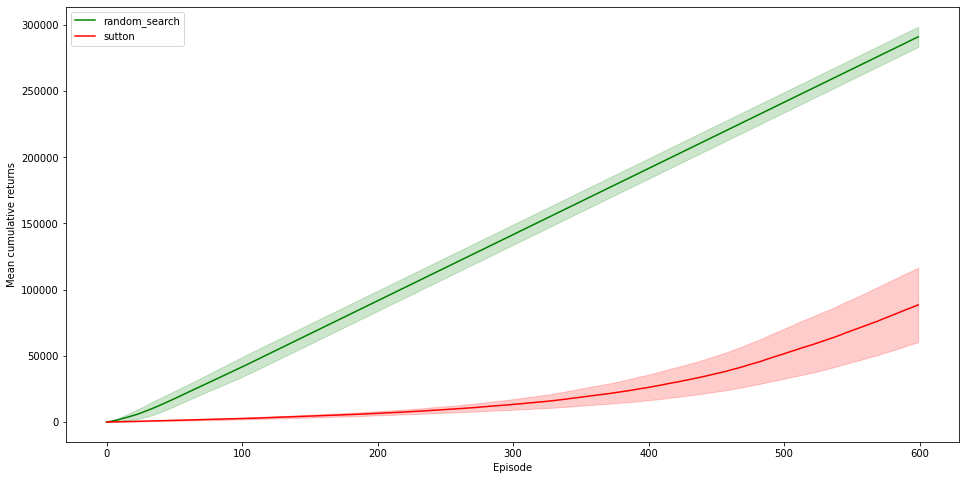

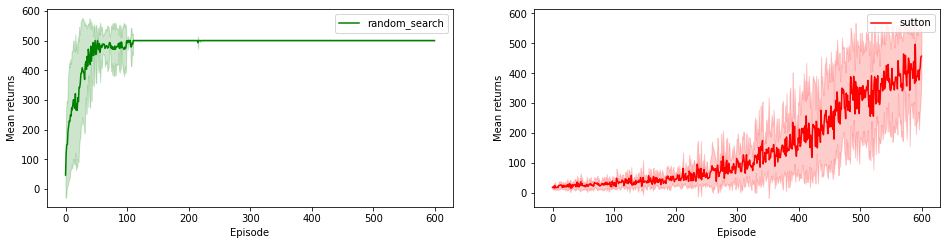

In [13]:
colors = ['g', 'r']
plt.figure(figsize=(16, 8))

for i, k in enumerate(returns):
    plt.plot(range(len(cum_means[k])), cum_means[k], color=colors[i], label=k)
    plt.fill_between(range(len(cum_means[k])),cum_means[k]-cum_stds[k], cum_means[k]+cum_stds[k], color=colors[i], alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Mean cumulative returns')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))

for i, k in enumerate(returns):
    plt.subplot(2, 2, i+1)
    plt.plot(range(len(non_cum_means[k])), non_cum_means[k], color=colors[i], label=k)
    plt.fill_between(range(len(non_cum_means[k])),non_cum_means[k]-non_cum_stds[k], non_cum_means[k]+non_cum_stds[k], color=colors[i], alpha=0.2)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Mean returns')



plt.show()